# CIFAR10 이미지 생성하기

## 작업환경 구성

- Spectral Noramlization을 위한 추가 라이브러리 설치
- 여러 기법들을 시도하는 모델들과 다른 방법들을 시도한 교육생들과의 실험 결과 비교를 위한 reproducibility 확보

In [1]:
! pip install -U tensorflow-addons

In [2]:
import os
import glob
import time
import random as python_random

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

학습에 다른 기법들이나 모델에 변화를 준 다른 교육생들과 실험 결과를 비교하기 위한 방법을 시도하였습니다. 
- 파이썬 seed, numpy seed, tensorflow seed를 동일한 숫자로 지정하였습니다.
- CuDNN을 사용하고 있기에, 이로부터 발생하는 차이도 방지하고자 환경변수를 설정하였습니다.

In [3]:
%matplotlib inline


def fix_seed():
    np.random.seed(123)
    python_random.seed(123)
    tf.random.set_seed(1234)
    os.environ["PYTHONHASHSEED"] = "1234"
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"


fix_seed()

## 데이터셋 준비

CIFAR10 데이터셋을 사용합니다. 라벨 데이터는 사용하지 않을 예정이므로 `_`로 표기합니다.

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

훈련 데이터는 (32, 32, 3)의 크기를 가지는 이미지 50,000장으로 구성되어 있습니다.

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


각 이미지는 0부터 255 사이의 값을 가지고 있습니다.

10개의 이미지를 확인합니다.

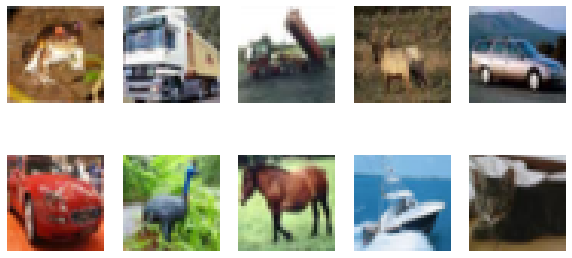

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_x[i])
    plt.axis("off")
plt.show()

효율적인 학습을 위해 이미지를 정규화합니다.

In [7]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


정규화 이후에는 -1에서 1사이의 값이 존재합니다.

데이터를 Tensorflow의 Dataset으로 준비합니다.

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)

생성자 모델을 설계합니다.

1. 8x8x256 개의 유닛을 가진 Fully Connected 계층(이하 FC) + Batch Normalization(이하 BN) + LeakyReLU
2. 128개의 필터를 가진 Transposed Convolution 계층 + BN + LeakyReLU
3. 64개의 필터를 가진 Transposed Convolution 계층 + BN + LeakyReLU
4. 3개의 필터를 가진 Transposed Convolution 계층 + BN + LeakyReLU

학습 가능한 파라미터를 가진 계층은 4개가 존재합니다.

## 모델 준비

### 생성 모델 준비

In [9]:
def make_generator_model():
    model = tf.keras.Sequential(name="generator_base")

    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(
        layers.Conv2DTranspose(
            128, kernel_size=(5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            64, kernel_size=(5, 5), strides=(2, 2), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(
        layers.Conv2DTranspose(
            3,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding="same",
            use_bias=False,
            activation="tanh",
        )
    )
    return model

In [10]:
generator = make_generator_model()
generator.summary()

Model: "generator_base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 128)      

생성자 모델에 입력할 임의의 데이터를 준비합니다.

In [11]:
noise = tf.random.normal([1, 100])

임의의 데이터를 생성 모델에 입력합니다. 모델 훈련이 목적이 아니기 때문에 `training` 인자를 `False`로 설정합니다.

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

100의 크기를 가지는 데이터를 입력하여 (32, 32, 3)의 크기를 가지는 데이터를 생성하였습니다.

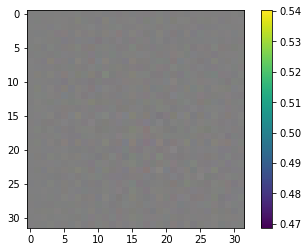

In [13]:
plt.imshow((generated_image[0] + 1) / 2)
plt.colorbar()
plt.show()

`tanh` 활성 함수를 사용하였기 때문에, 값이 -1에서 1사이에 분포합니다.

판별 모델을 설계합니다.

1. 64개의 필터를 가진 Convolution 계층 + LeakyReLU + Dropout
2. 128개의 필터를 가진 Convolution 계층 + LeakyReLU + Dropout
3. 1개의 유닛을 가진 FC

학습 가능한 파라미터를 가진 계층은 3개입니다.

### 판별 모델 준비

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential(name="discriminator_base")

    model.add(
        layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding="same", input_shape=[32, 32, 3]
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "discriminator_base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)       

판별 모델 작동 확인을 위해 생성 모델이 생성한 결과를 입력합니다.

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00018481]], dtype=float32)>

손실 함수로 Binary Cross Entropy를 사용합니다. `from_logits` 인자는 예측값이 확률 분포에 맞게 변환되어 있는가에 따라 설정합니다. 판별 모델에서 가장 마지막 FC 계층 이후에 별도의 함수를 적용하지 않았기 때문에 `True`로 설정합니다.  
함수의 기본값은 `False`이지만, TF API 문서에는 `True`로 사용하기를 권장하고 있습니다.[(TF API 문서)](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#used-in-the-notebooks)

## 손실 함수 및 최적화 함수

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

생성 모델이 사용할 손실 함수를 작성합니다. 손실함수는 생성 모델의 결과가 1에 가까워질수록 loss가 작아지도록 설정합니다.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

판별 모델이 사용할 손실 함수를 작성합니다.  
생성 모델의 결과(`fake_output`)는 0에 가까워질수록 loss가 작아지도록 설정하고, 실제 이미지(`real_output`)는 1에 가까워질수록 loss가 작아지도록 설정합니다.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

판별 모델의 정확도를 측정하는 함수를 작성합니다.  
`real_accuracy`와 `fake_accuracy`가 가장 비슷한 0.5의 결과가 이상적이라고 할 수 있습니다.  
`real_accuracy`에 대해서는 0.5 이상의 값들의 평균을 사용하여 정확도를 계산합니다.  
`fake_accuracy`에 대해서는 0.5 미만의 값들의 평균을 사용하여 정확도를 계산합니다.

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(
        tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32)
    )
    fake_accuracy = tf.reduce_mean(
        tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32)
    )
    return real_accuracy, fake_accuracy

생성 모델과 판별 모델에 대한 최적화 함수를 준비합니다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

모델이 학습되는 과정에서 결과물이 어떻게 달라지는지 확인하기 위해 훈련 단계에서 사용할 데이터를 준비합니다.  
정규 분포를 따르는 16개의 샘플을 생성합니다.

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 모델 훈련

훈련 스텝을 진행하는 함수를 작성합니다.
1. 정규 분포를 따르는 입력 데이터를 준비합니다.
2. 데이터를 생성 모델에 입력합니다.
3. 판별 모델이 생성 모델의 출력과 실제 이미지에 대해 예측합니다.
4. 생성 모델에 대한 loss와 판별 모델에 대한 loss를 계산합니다.
5. 판별 모델의 정확도를 계산합니다.
6. gradient를 계산하고 최적화를 진행합니다.
7. 함수는 생성 모델에 대한 loss, 판별 모델에 대한 loss, 실제 이미지에 대한 정확도, 가짜 이미지에 대한 정확도 총 4가지를 return 합니다.

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

모델의 훈련 진행이 어떻게 이루어지고 있는지 확인하기 위해 생성한 샘플 데이터를 사용하여 이미지를 생성하고 출력하는 함수를 작성합니다.

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :] + 1) / 2)
        plt.axis("off")

    plt.savefig(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{epoch:04d}_iter_{it:03d}.png"
    )
    plt.show()

훈련을 진행하면서 loss와 accuracy 변화를 그래프로 그려주는 함수를 작성합니다.

In [25]:
from matplotlib.pylab import rcParams
import seaborn as sns


rcParams["figure.figsize"] = 16, 8


def draw_train_history(history, epoch):
    plt.subplot(211)
    sns.regplot(
        x=[x for x in range(len(history["gen_loss"]))],
        y=np.array(history["gen_loss"]),
        line_kws={"color": "purple"},
    )
    sns.regplot(
        x=[x for x in range(len(history["disc_loss"]))],
        y=np.array(history["disc_loss"]),
        line_kws={"color": "red"},
    )
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("batch iters")
    plt.legend(["gen_loss", "disc_loss"], loc="upper left")

    plt.subplot(212)
    sns.regplot(
        x=[x for x in range(len(history["fake_accuracy"]))],
        y=np.array(history["fake_accuracy"]),
        line_kws={"color": "purple"},
    )
    sns.regplot(
        x=[x for x in range(len(history["real_accuracy"]))],
        y=np.array(history["real_accuracy"]),
        line_kws={"color": "red"},
    )
    plt.title("discriminator accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("batch iters")
    plt.legend(["fake_accuracy", "real_accuracy"], loc="upper left")
    plt.tight_layout()

    plt.savefig(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{epoch:04d}.png"
    )
    plt.show()

훈련이 중단되더라도 추후 다시 진행 상황을 불러와 훈련이 가능하도록 checkpoint를 사용합니다.

In [26]:
checkpoint_dir = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/training_checkpoints/base"
)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

훈련을 진행하는 함수를 작성합니다.
1. 훈련 진행 과정을 기록할 dict를 `history`라는 이름으로 준비합니다.
2. 매 epoch 마다 수행 시간을 측정합니다.
3. 데이터셋을 배치 단위로 불러와 `train_step` 함수를 호출하여 훈련 단계를 진행합니다.
4. 훈련을 통해 얻은 정보를 `history`에 저장합니다.
5. 50 step 마다 샘플 데이터를 이용하여 생성한 이미지를 출력합니다.
6. 주기적으로 checkpoint를 저장합니다.

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        "gen_loss": [],
        "disc_loss": [],
        "real_accuracy": [],
        "fake_accuracy": [],
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f"Epoch {epoch + 1} | iter {it + 1}")
                print(
                    f"Time for epoch { epoch + 1} : {int(time.time() - epoch_start)} sec"
                )

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training : {int(time.time() - start)} sec")

        draw_train_history(history, epoch)

epoch과 checkpoint를 저장할 주기를 설정합니다.

In [28]:
save_every = 5
EPOCHS = 500

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

훈련을 진행합니다. 훈련이 진행됨에 따라 결과가 어떻게 달라지는지 확인하기 위해 생성한 데이터 16개를 주기적으로 출력합니다.  
코드 수행시간을 측정하는 jupyter magic command `%%time`을 사용합니다. 해당 명령어는 셀의 실행 시간을 측정합니다.

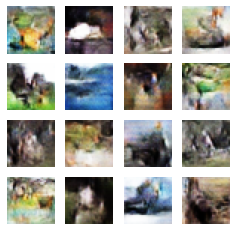

Time for training : 15728 sec


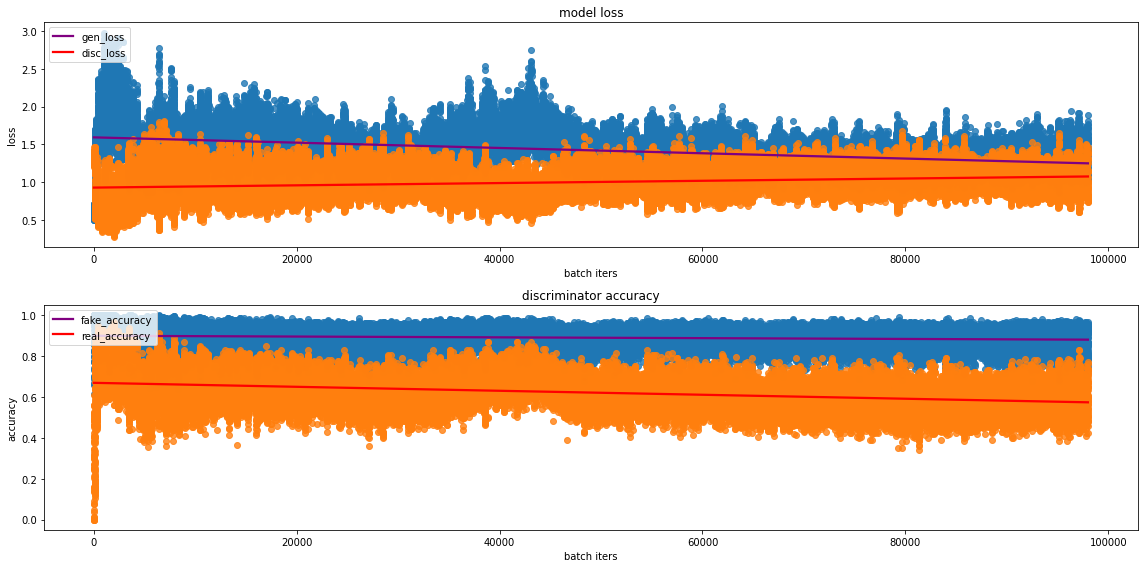

CPU times: user 5h 13min 3s, sys: 1h 52min 35s, total: 7h 5min 39s
Wall time: 4h 22min 47s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

**출력 이미지에 대한 분석**  
- 객체로 구별할 수 있을 만한 형태나 특징이 보이지 않습니다.  
- 큰 배치 사이즈로 인해 생성 모델보다 판별 모델의 성능이 뛰어나 학습이 제대로 진행되지 않는 것으로 판단됩니다. 이에 따라 배치 사이즈를 조절하는 추가 실험을 진행합니다.

**그래프에 대한 분석**
- 생성 모델에 대한 loss는 장기적으로 감소하고 있는 것으로 보입니다.
- 판별 모델에 대한 loss는 장기적으로 증가하고 있는 것으로 보입니다.
- 판별 모델의 fake image에 대한 accuracy는 특정한 추세가 관찰되지 않습니다.
- 판별 모델의 real image에 대한 accuracy는 작은 기울기로 감소하고 있는 것으로 확인됩니다.

## 훈련 결과 확인

훈련 과정에서 생성한 checkpoint에서 모델을 불러와 이미지 생성 결과를 확인합니다.

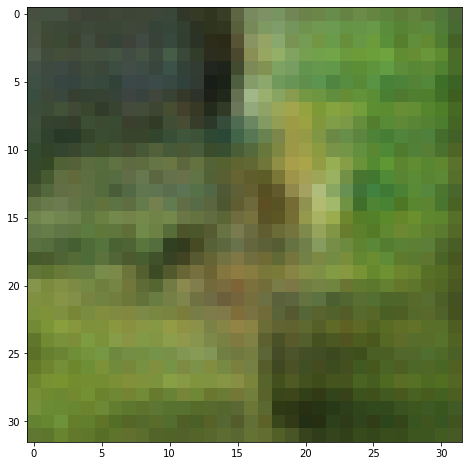

In [30]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

배경으로부터 구별되는 객체의 형태가 보이지 않습니다.

epoch 마다 저장한 이미지들을 하나의 gif 파일로 만들어 훈련 과정이 진행되며 이미지의 변화를 쉽게 확인할 수 있습니다.

In [31]:
anim_file = os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_base.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png"
    )
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

## 성능 개선을 위한 추가 실험

성능 개선을 위해 다음과 같은 방법들을 시도하였습니다.
1. 하이퍼파라미터 조정
    - 배치 사이즈 변경(더 작은 배치 사이즈)
    - Two Time-scale Update Rule(판별 모델에 더 높은 학습률 설정)
2. Spectral Normalization 적용
3. Label Smoothing 적용
4. TTUR & Spectral Normalization & Label Smoothing 적용

### 배치 사이즈 변경 (->128)

앞선 256의 배치 사이즈를 설정한 실험에서 판별 모델의 성능이 뛰어나 생성 모델이 제대로 학습되지 않는 것으로 판단, 작은 배치 사이즈를 설정하여 모델을 훈련하는 실험을 진행합니다.

In [32]:
fix_seed()

<IPython.core.display.Javascript object>

In [33]:
BATCH_SIZE = 128

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)

<IPython.core.display.Javascript object>

In [34]:
discriminator = make_discriminator_model()
generator = make_generator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/training_checkpoints/batch_128"
)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss, real_accuracy, fake_accuracy


def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        "gen_loss": [],
        "disc_loss": [],
        "real_accuracy": [],
        "fake_accuracy": [],
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f"Epoch {epoch + 1} | iter {it + 1}")
                print(
                    f"Time for epoch { epoch + 1} : {int(time.time() - epoch_start)} sec"
                )

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training : {int(time.time() - start)} sec")

        draw_train_history(history, epoch)

<IPython.core.display.Javascript object>

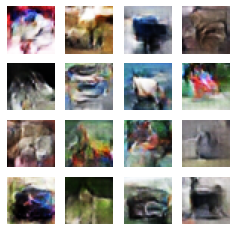

Time for training : 27282 sec


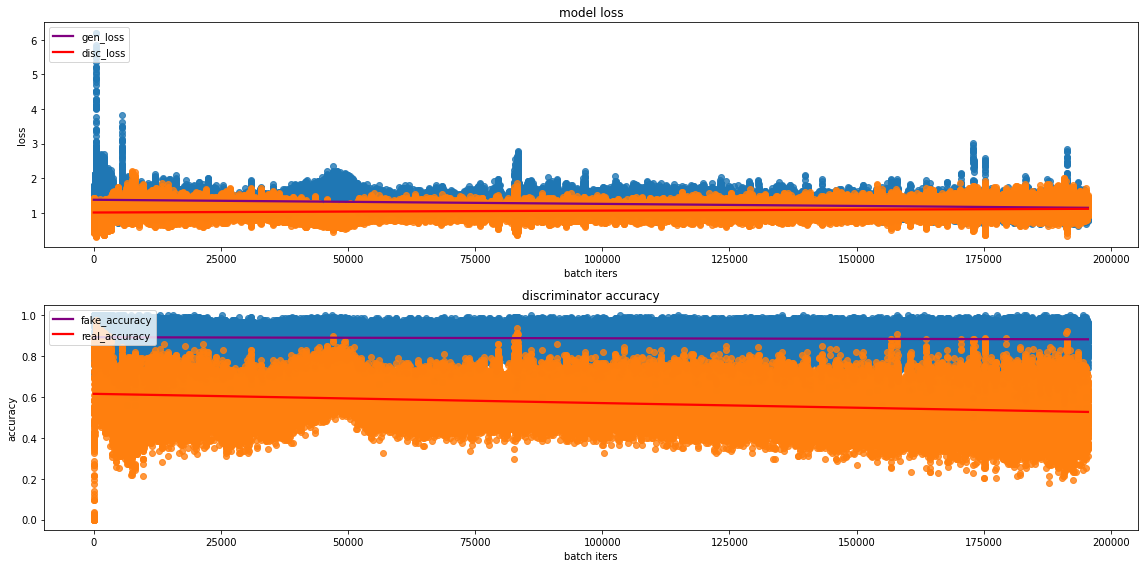

CPU times: user 10h 22min 35s, sys: 5h 39min, total: 16h 1min 36s
Wall time: 7h 36min 4s


<IPython.core.display.Javascript object>

In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

**출력 이미지에 대한 분석**  
- 여전히 객체로 구별할 수 있을 만한 형태나 특징이 보이지 않습니다.  
- 더 큰 배치 사이즈(256)로 설정한 모델과 비교하여 나아진 결과로는 확인되지 않습니다.

**그래프에 대한 분석**
- 생성 모델에 대한 loss는 장기적으로 감소하고 있는 것으로 보입니다.
- 판별 모델에 대한 loss는 장기적으로 증가하고 있는 것으로 보입니다.
- 판별 모델의 fake image에 대한 accuracy는 특정한 추세가 관찰되지 않습니다.
- 판별 모델의 real image에 대한 accuracy는 작은 기울기로 감소하고 있는 것으로 확인됩니다.

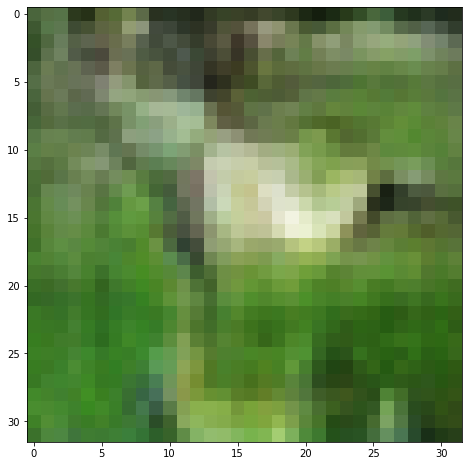

<IPython.core.display.Javascript object>

In [36]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

배치 크기가 256인 모델의 출력 결과와 비교하여 중앙에 특정 물체의 형태를 추측할 수 있습니다.

In [37]:
anim_file = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_batch_128.gif"
)

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png"
    )
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<IPython.core.display.Javascript object>

### 배치 사이즈 변경 (->64)

- loss와 accuracy에는 큰 변화가 없었으나 샘플 이미지에 배경과 구별되는 객체의 형태가 점차 뚜렷해짐에 따라 더 작은 배치 사이즈에 대한 실험을 진행하였습니다.  
- Epoch은 동일하게 유지한 채로 배치 사이즈 변경 실험을 진행할 계획이었으나, 학습을 위해 할당받는 리소스의 사용 시간 제한으로 인하여 epoch을 약 60%인 300으로 조절하여 훈련을 진행하였습니다. 앞선 실험에서 배치 사이즈가 줄어들면서 배경이 아닌 물체의 형태가 상대적으로 더 선명해지는 경향을 확인하여 epoch을 감소시켜서라도 실험할 가치가 있다고 판단했습니다.

In [38]:
fix_seed()

<IPython.core.display.Javascript object>

In [39]:
BATCH_SIZE = 64

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)

EPOCHS = 300

<IPython.core.display.Javascript object>

In [40]:
discriminator = make_discriminator_model()
generator = make_generator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/training_checkpoints/batch_64"
)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss, real_accuracy, fake_accuracy


def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        "gen_loss": [],
        "disc_loss": [],
        "real_accuracy": [],
        "fake_accuracy": [],
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f"Epoch {epoch + 1} | iter {it + 1}")
                print(
                    f"Time for epoch { epoch + 1} : {int(time.time() - epoch_start)} sec"
                )

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training : {int(time.time() - start)} sec")

        draw_train_history(history, epoch)

<IPython.core.display.Javascript object>

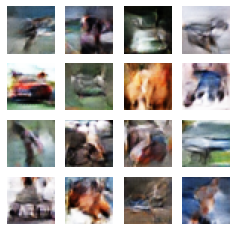

Time for training : 20737 sec


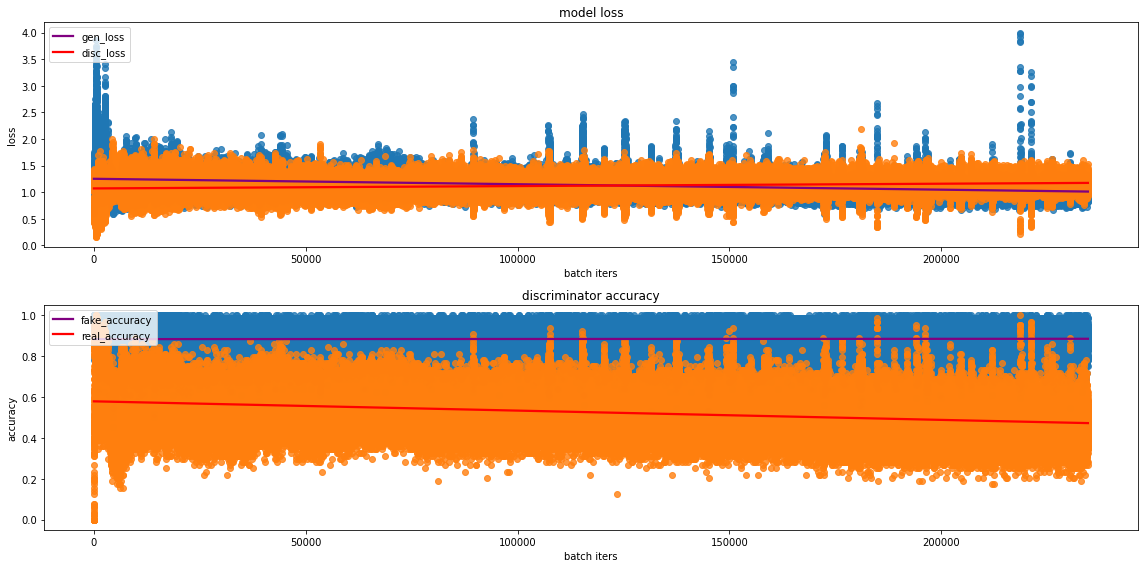

CPU times: user 7h 20min 51s, sys: 4h 23min 37s, total: 11h 44min 29s
Wall time: 5h 47min 14s


<IPython.core.display.Javascript object>

In [41]:
%%time
train(train_dataset, EPOCHS, save_every)

**출력 이미지에 대한 분석**  
- 여전히 객체로 구별할 수 있을 만한 형태나 특징이 보이지 않습니다.  
- 16개의 이미지 전체적으로는 더 큰 배치 사이즈(128)로 설정한 모델과 비교하여 크게 나아진 결과로는 확인되지 않습니다. 다만 일부 이미지에서 이미 알고 있는 객체의 형태가 관측됩니다.
- 2번째 행 첫번째 이미지는 자동차의 형태로 추측할 수 있습니다.
- 4번째 행 마지막 이미지는 동물의 머리 형태로 추측할 수 있습니다.

**그래프에 대한 분석**
- 생성 모델에 대한 loss는 장기적으로 감소하고 있는 것으로 보입니다.
- 판별 모델에 대한 loss는 장기적으로 증가하고 있는 것으로 보입니다.
- 판별 모델의 fake image에 대한 accuracy는 특정한 추세가 관찰되지 않습니다.
- 판별 모델의 real image에 대한 accuracy는 작은 기울기로 감소하고 있는 것으로 확인됩니다.

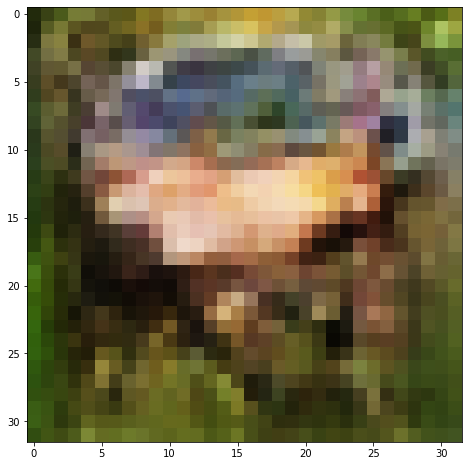

<IPython.core.display.Javascript object>

In [42]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

더 큰 배치 사이즈로 설정한 모델의 출력 결과와 비교하여 배경과 구분되는 객체의 형태와 색상이 뚜렷해졌습니다.

In [43]:
anim_file = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_batch_64.gif"
)

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png"
    )
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<IPython.core.display.Javascript object>

### 배치 사이즈 및 Epoch 설정

앞선 실험에서 배치 사이즈를 줄이는 것이 성능 향상에 도움이 되는 것으로 판단되었습니다. 이에 따라 이후 진행되는 실험에서는 배치 사이즈를 64로 설정하고, 사용할 수 있는 자원의 시간 제한 때문에 epoch을 300으로 설정하였습니다.

In [44]:
EPOCHS = 300

BATCH_SIZE = 64

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
)

<IPython.core.display.Javascript object>

### Two Time-Scale Update Rule

다음의 논문에 소개된 방법으로 생성 모델과 판별 모델의 학습률을 다르게 적용합니다. 이번 실험에서는 판별 모델의 학습률을 상대적으로 높게 설정하였습니다. [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/pdf/1706.08500v6.pdf)

In [45]:
fix_seed()

<IPython.core.display.Javascript object>

판별 모델의 학습률을 생성 모델과 비교하여 5배 큰 5e-4 로 설정합니다.

In [46]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

<IPython.core.display.Javascript object>

In [47]:
checkpoint_dir = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/training_checkpoints/batch_ttur"
)
os.makedirs(checkpoint_dir, exist_ok=True)

discriminator = make_discriminator_model()
generator = make_generator_model()

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss, real_accuracy, fake_accuracy


def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        "gen_loss": [],
        "disc_loss": [],
        "real_accuracy": [],
        "fake_accuracy": [],
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f"Epoch {epoch + 1} | iter {it + 1}")
                print(
                    f"Time for epoch { epoch + 1} : {int(time.time() - epoch_start)} sec"
                )

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training : {int(time.time() - start)} sec")

        draw_train_history(history, epoch)

<IPython.core.display.Javascript object>

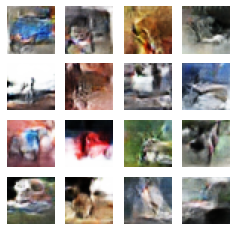

Time for training : 20341 sec


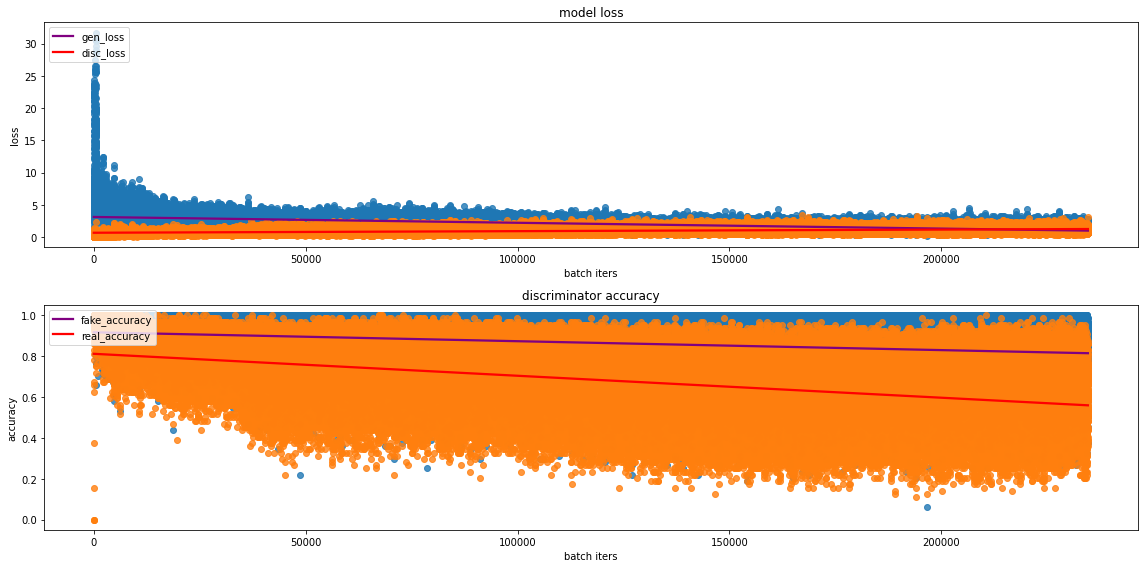

CPU times: user 7h 13min 31s, sys: 4h 14min 54s, total: 11h 28min 25s
Wall time: 5h 40min 37s


<IPython.core.display.Javascript object>

In [48]:
%%time
train(train_dataset, EPOCHS, save_every)

**출력 이미지에 대한 분석**  
- 여전히 객체로 구별할 수 있을 만한 형태나 특징이 보이지 않습니다.  
- 16개의 이미지 전체적으로는 TTUR을 적용하지 않은 모델과 비교하여 크게 나아진 결과로는 확인되지 않습니다.

**그래프에 대한 분석**
- 생성 모델에 대한 loss는 장기적으로 감소하고 있는 것으로 보입니다.
- 판별 모델에 대한 loss는 장기적으로 증가하고 있는 것으로 보입니다.
- 판별 모델의 fake image에 대한 accuracy는 작은 기울기로 감소하고 있는 것으로 확인됩니다. TTUR을 적용하지 않은 모델과 비교하여 훈련의 양상이 바뀌었습니다.
- 판별 모델의 real image에 대한 accuracy는 작은 기울기로 감소하고 있는 것으로 확인됩니다.

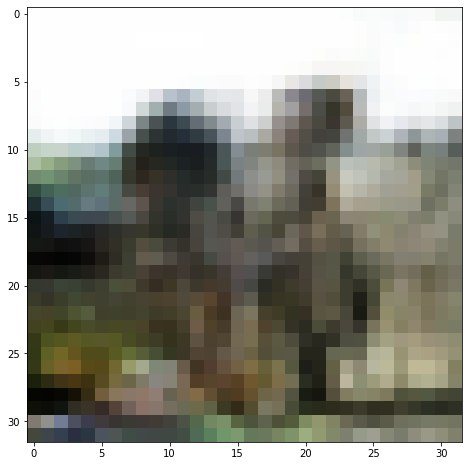

<IPython.core.display.Javascript object>

In [49]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

TTUR을 적용하지 않은 모델과 비교하여 전혀 다른 이미지의 결과를 얻었습니다. 두 귀가 달린 동물의 머리로 추정할 수 있는 결과입니다.

In [50]:
anim_file = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_batch_ttur.gif"
)

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png"
    )
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<IPython.core.display.Javascript object>

### Spectral Normalization

Spectral Normalization(SN)은 [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957) 논문에서 처음 소개된 방법으로, 판별 모델의 학습을 안정시킬 수 있는 기법입니다.

In [51]:
fix_seed()

<IPython.core.display.Javascript object>

기본 모델에 존재하던 Batch Normalization을 제거하고 Spectral Noramlization을 추가하였습니다.

In [52]:
from tensorflow_addons.layers import SpectralNormalization


def make_discriminator_model_sn():
    model = tf.keras.Sequential(name="discriminator_spectral")
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(
        SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(
        SpectralNormalization(
            layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")
        )
    )
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [53]:
discriminator = make_discriminator_model_sn()
discriminator.summary()

Model: "discriminator_spectral"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spectral_normalization (Spec (None, 16, 16, 64)        4928      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
spectral_normalization_1 (Sp (None, 8, 8, 128)         205056    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)   

In [54]:
generator = make_generator_model()
generator.summary()

Model: "generator_base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 128)      

In [55]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/training_checkpoints/sn"
)
os.makedirs(checkpoint_dir, exist_ok=True)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss, real_accuracy, fake_accuracy


def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        "gen_loss": [],
        "disc_loss": [],
        "real_accuracy": [],
        "fake_accuracy": [],
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f"Epoch {epoch + 1} | iter {it + 1}")
                print(
                    f"Time for epoch { epoch + 1} : {int(time.time() - epoch_start)} sec"
                )

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training : {int(time.time() - start)} sec")

        draw_train_history(history, epoch)

<IPython.core.display.Javascript object>

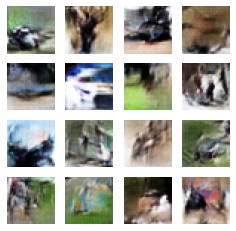

Time for training : 20718 sec


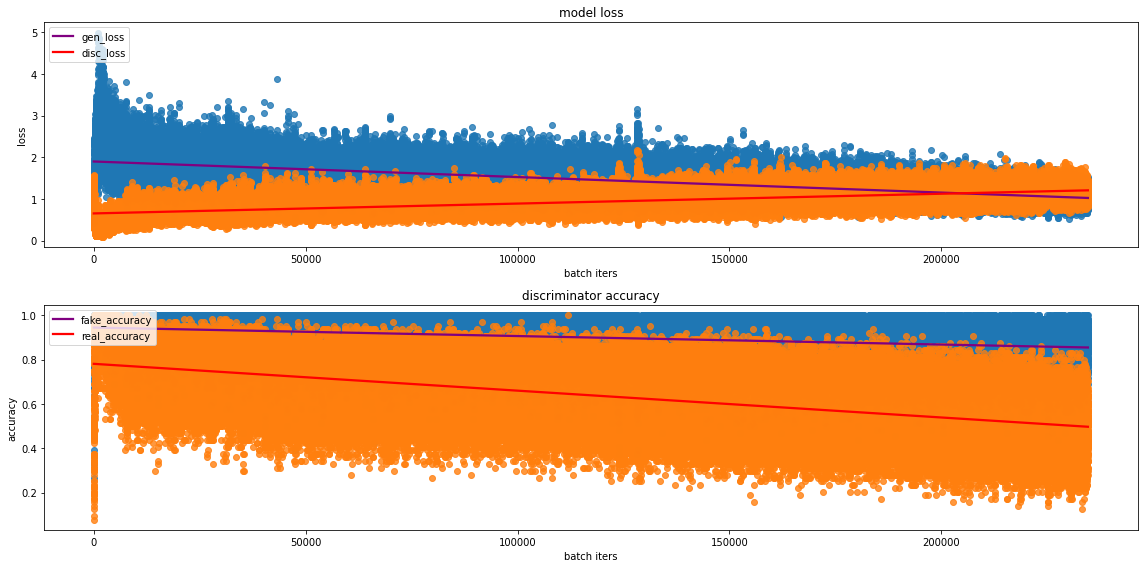

CPU times: user 7h 12min 27s, sys: 4h 14min 48s, total: 11h 27min 16s
Wall time: 5h 46min 56s


<IPython.core.display.Javascript object>

In [56]:
%%time
train(train_dataset, EPOCHS, save_every)

**출력 이미지에 대한 분석**  
- 여전히 객체로 구별할 수 있을 만한 형태나 특징이 보이지 않습니다.  
- 16개의 이미지 전체적으로는 Spectral Normalization을 적용하지 않은 모델과 비교하여 크게 나아진 결과로는 확인되지 않습니다.

**그래프에 대한 분석**
- 생성 모델에 대한 loss는 장기적으로 감소하고 있는 것으로 보입니다.
- 판별 모델에 대한 loss는 장기적으로 증가하고 있는 것으로 보입니다.
- SN을 적용하지 않은 모델과 비교하여 판별 모델의 accuracy가 조금 더 큰 기울기로 감소하는 것을 확인할 수 있습니다.
    - epoch을 추가하여 훈련을 진행하면 더 좋은 결과가 나올 수 있을 것으로 기대됩니다.

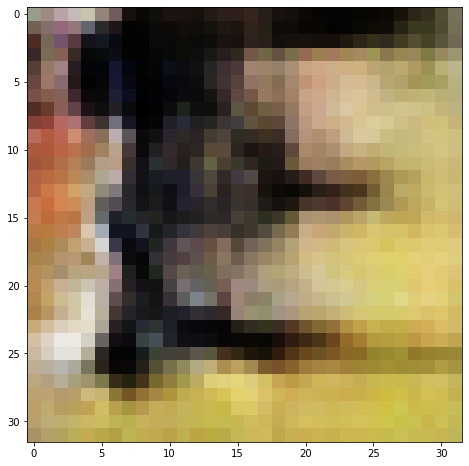

<IPython.core.display.Javascript object>

In [57]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

배경과 분리되는 객체의 형태가 뚜렷하게 보입니다. 하지만 CIFAR-10 데이터셋에 속하는 어떠한 클래스 분류에도 해당하지 않는 것으로 보입니다.

In [58]:
anim_file = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_sn.gif"
)

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png"
    )
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<IPython.core.display.Javascript object>

### Label Smoothing

라벨 스무딩은 real image에 대한 label을 1이 아니라 0.9와 같이 1보다 작은 숫자로 설정하는 기법입니다. 판별 모델의 손실 함수에서 real image에 대한 confidence가 너무 높아지지 않도록 제한할 수 있습니다.

In [59]:
fix_seed()

<IPython.core.display.Javascript object>

GAN에서 Label Smoothing은 판별 모델의 real image에 대한 loss에만 적용합니다(One-sided Label Smoothing).

In [60]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

<IPython.core.display.Javascript object>

In [61]:
discriminator = make_discriminator_model()
generator = make_generator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/training_checkpoints/smooth"
)
os.makedirs(checkpoint_dir, exist_ok=True)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )
    return gen_loss, disc_loss, real_accuracy, fake_accuracy


def train(dataset, epochs, save_every):
    start = time.time()
    history = {
        "gen_loss": [],
        "disc_loss": [],
        "real_accuracy": [],
        "fake_accuracy": [],
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history["gen_loss"].append(gen_loss)
            history["disc_loss"].append(disc_loss)
            history["real_accuracy"].append(real_accuracy)
            history["fake_accuracy"].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f"Epoch {epoch + 1} | iter {it + 1}")
                print(
                    f"Time for epoch { epoch + 1} : {int(time.time() - epoch_start)} sec"
                )

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f"Time for training : {int(time.time() - start)} sec")

        draw_train_history(history, epoch)

<IPython.core.display.Javascript object>

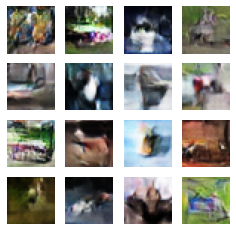

Time for training : 20729 sec


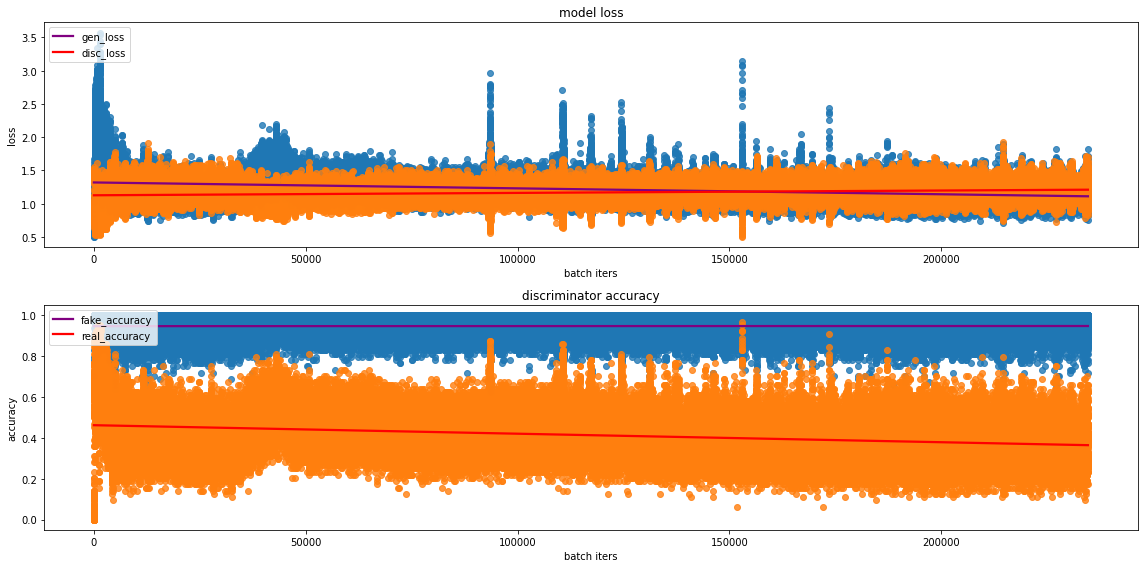

CPU times: user 7h 18min 52s, sys: 4h 23min 1s, total: 11h 41min 53s
Wall time: 5h 47min 6s


<IPython.core.display.Javascript object>

In [62]:
%%time
train(train_dataset, EPOCHS, save_every)

**출력 이미지에 대한 분석**  
- 여전히 객체로 구별할 수 있을 만한 형태나 특징이 보이지 않습니다.  
- 16개의 이미지 전체적으로는 Label Smoothing을 적용하지 않은 모델과 비교하여 크게 나아진 결과로는 확인되지 않습니다.

**그래프에 대한 분석**
- 생성 모델에 대한 loss는 장기적으로 감소하고 있는 것으로 보입니다.
- 판별 모델에 대한 loss는 장기적으로 증가하고 있는 것으로 보입니다.
- 판별 모델의 real accuracy가 0.5 이하로 작아지고 있지만, fake accuracy는 아주 높은 값을 유지하고 있어 훈련이 원하는 방향으로 진행되지 않은 것으로 생각됩니다.

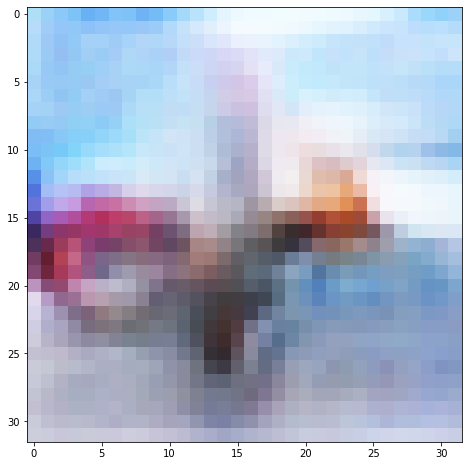

<IPython.core.display.Javascript object>

In [63]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

파란색의 배경과 분리되는 객체의 형태가 뚜렷하게 존재하나 특정 클래스로 분류하기 힘든 이미지의 결과를 얻었습니다.

In [64]:
anim_file = (
    os.getenv("HOME") + "/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_smooth.gif"
)

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob(
        f"{os.getenv('HOME')}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png"
    )
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<IPython.core.display.Javascript object>

## 결과 이미지

1. 실험 설정, e=epoch
2. 훈련 진행에 따른 출력 이미지 변화
3. 출력 이미지
4. 동일한 노이즈 입력에 대한 결과

| Base (Batch 256), e=500 | Batch 128, e=500 | Batch 64, e=300 | TTUR, e=300 | Spectral Norm, e=300 | Labsel Smooth, e=300 |
| --- | --- | --- | --- | --- | --- |
| ![](img/cifar10_dcgan_base.gif) | ![](img/cifar10_dcgan_batch_128.gif) | ![](img/cifar10_dcgan_batch_64.gif) | ![](img/cifar10_dcgan_batch_ttur.gif) | ![](img/cifar10_dcgan_sn.gif) | ![](img/cifar10_dcgan_smooth.gif) |
| ![](img/output_base.png) | ![](img/output_128.png) | ![](img/output_64.png) | ![](img/output_ttur.png) | ![](img/output_sn.png) | ![](img/output_label.png) |
| ![](img/noise_base.png) | ![](img/noise_128.png) | ![](img/noise_64.png) | ![](img/noise_ttur.png) | ![](img/noise_sn.png) | ![](img/noise_label.png) |

## 결론

- 각각의 모델을 학습하기 위한 시간이 길어 충분한 실험을 진행하지는 못하였지만, 배치 사이즈가 작아지면 성능이 향상되는 것으로 생각됩니다.
- 성능 개선을 위해 시도한 방법들이 항상 성공적이지는 않았습니다.
    - TTUR과 SN은 결과 이미지는 사람이 판단하기에 충분히 형태를 갖추지는 않았지만, loss와 accuracy가 원하는 방향으로 변하는 것을 확인할 수 있었습니다.
    - Label Smoothing은 학습이 원하는 방향으로 이루어지지 않아 성능 향상에 도움이 되지 않았습니다.

## 루브릭

| 평가문항 | 상세기준 |
| --- | --- |
| 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. | 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다. |
| 2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. | gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다. |
| 3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다. | 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다. |

### 루브릭 자체평가

1. 객체의 종류을 구별할 수 있는 결과를 얻었다.
2. 생성 이미지의 품질 향상을 시각화하고, fake accuracy의 지속적인 감소를 확인할 수 있었다.
3. 추가적인 시도를 통하여 학습이 원하는 방향으로 이루어지는 결과를 얻을 수 있었다.